# Dynamic RNN Make Pratical

Modify from this [notebook](https://www.kaggle.com/winternguyen/predict-household-electric-power-using-lstms)

Download the dataset from this [link](https://www.kaggle.com/uciml/electric-power-consumption-data-set) and put this dataset under the `dataset` folder.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

from typing import Union

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import & cleaning data

Importing the txt file takes more time than that of csv file.

In [2]:
from cost_estimator import Loader, Preprocessor, RegressionModels, Task

def get_df(dataset_path: Union[str, list]):
    ou_name = 'OU2 - Initialize Thread'
    task_name = 'latency'
    features = ['System CPU Load', 'Process CPU Load',
                'System Load Average', 'Thread Active Count']
    sample_size = 10000

    task = Task(ou_name, task_name)
    if isinstance(dataset_path, str):
        dataset_path = [dataset_path]
        
    df_list = []

    for path in dataset_path:
        # sub_task_name = f'basic1-RTE-{i}'

        loader = Loader(path, server_count=1, n_jobs=8)
        df_features = loader.load_features_as_df(load_from_pkl=True)
        df_latencies = loader.load_latencies_as_df(load_from_pkl=True)
        dict_depend = loader.load_dependencies_as_dict()
        
        df_list.append((df_features, df_latencies, dict_depend))

        # print(f'\n\n---------------------- Basic1-RTE-{i} Latency ----------------------')
        psr = Preprocessor(df_features, df_latencies, ou_name)
        psr.drop_warmup_data()

        mean_before_filter = float(psr.get_label().mean())
        std_before_filter = float(psr.get_label().std())

        psr.drop_outlier_and_na(drop_alg='std')

        mean_after_filter = float(psr.get_label().mean())
        std_after_filter = float(psr.get_label().std())

        psr.sample_features(sample_size)
        psr.specify_features(features)
        
    return df_list

In [3]:
# df_list = get_df(dataset_path=['dataset/mmt-rte-45-server-1-no-dist-tx/training-data'])
df_list = get_df(dataset_path=['/opt/shared-disk2/sychou/dynamic_rnn/lock_overhead_exp3/rte-100/reports'])

Load features from /opt/shared-disk2/sychou/dynamic_rnn/lock_overhead_exp3/rte-100/reports/transaction-features.pkl
Load label from /opt/shared-disk2/sychou/dynamic_rnn/lock_overhead_exp3/rte-100/reports/latency.pkl
Drop warmup size: 94055, Size before/after drop warmup data: 299248/205193
Drop na size: 0, Size before/after drop na data: 205193/205193
Drop outlier size: 34599, Size before/after drop outlier data: 205193/170594
Drop sample size: 170594, Size before/after sample: 170594/10000
current feature columns: ['System CPU Load', 'Process CPU Load', 'System Load Average', 'Thread Active Count']


In [29]:
def fix_NaN(df):
    df.isnull().sum()
    df = df.fillna(df.mean())
    df.isnull().sum()
    # return df
    
def recompute_overhead_ou3(df_feature):
    df_feature.loc[:, 'OU3 - xLock Overhead'] = df_feature['OU3 - Acquire Locks'] - df_feature['OU3 - xLock Waiting']
    df_feature.loc[:, 'OU3 - sLock Overhead'] = df_feature['OU3 - Acquire Locks'] - df_feature['OU3 - sLock Waiting']
    
    return df_feature

def make_dataset(df_features: pd.DataFrame, df_latencies: pd.DataFrame, dict_depend: dict, is_recompute_overhead_ou3=False):
    df_start_time = df_features[['Transaction ID', 'Start Time']]
    df_total_time = df_latencies[['Total']]
    df_feature = df_latencies[['Is Distributed', 'Total', 'OU0 - Broadcast', 'OU0 - ROUTE', 'OU1 - Generate Plan', 'OU2 - Initialize Thread',
                               'OU3 - Acquire Locks', 
#                                New features
                               'OU3 - xLock Waiting', 'OU3 - sLock Waiting', 'OU3 - xLock Overhead', 'OU3 - sLock Overhead', 'OU3 - xAnchor Waiting', 'OU3 - sAnchor Waiting', 
                               'OU4 - Read from Local', 'OU5M - Read from Remote', 'OU6 - Execute Arithmetic Logic', 
                               'NonOU - Push to Remote', 'OU7 - Write to Local', 'OU8 - Commit']]
    
    if is_recompute_overhead_ou3:
        df_feature = recompute_overhead_ou3(df_feature)
        
    max_depend_num = 0
    depends = []
    
    for k in dict_depend.keys():
        depend_num = len(dict_depend[k])
        if max_depend_num < depend_num:
            max_depend_num = depend_num
        
    for index, row in df_features.iterrows():
        # print(f"ID: {row['Transaction ID']} | Start: {row['Start Time']} | Total: {row['Total']}") 
        if dict_depend is not None:
            depend_txns = dict_depend.get(row['Transaction ID'], None)
            
#             If no dependent Txns, assign a empty list
            if depend_txns is None:
                depend_txns = []
            else:
                for i in range(len(depend_txns)):
                    depend_txns[i] = row['Transaction ID'] - depend_txns[i]
                
            depend_txns_num = len(depend_txns)

            if depend_txns_num <= max_depend_num:
                depends.append(depend_txns + ([0] * (max_depend_num - depend_txns_num)))
            else:
#                 If exceed the maximum number of dependenet Txns, truncate
                depends.append(depend_txns[:max_depend_num])
    
    df_depends = pd.DataFrame(depends, columns=[f"dep-{i}" for i in range(1, max_depend_num + 1)], dtype=np.int64)
    df_concat = pd.concat([df_start_time, df_feature, df_depends], axis=1)
    df_concat['Is Distributed'] = df_concat['Is Distributed'].astype(int)
    
    # df_X = df_concat.drop(columns=['OU3 - Acquire Locks'])
    df_X = df_concat
    df_Y = pd.DataFrame(df_features['Start Time'] + df_total_time['Total'], columns=['End Time'])
    
    return df_X, df_Y

def draw_cov_mat(features: pd.DataFrame, title: str=None, path: str=None) -> np.array:
    # Covariance
    sc = StandardScaler()
    Z = sc.fit_transform(features)
    R = np.dot(Z.T, Z) / Z.shape[0]

    plt.figure(figsize=(10, 8), facecolor=(1, 1, 1))
    sns.set(font_scale=1.0)

    ticklabels = [s for s in features.columns]

    hm = sns.heatmap(
        R,
        cbar = True,
        square = True,
        yticklabels = ticklabels,
        xticklabels = ticklabels
    )

    if title is not None:
        plt.title(f"{title}")
    plt.tight_layout()
    if path is not None:
        plt.savefig(f'{path}', dpi = 300)
    plt.show()

    sns.reset_orig()
    return R

def draw_bar_chart(features: pd.DataFrame, title: str=None, xlabel: str=None, ylabel: str=None, path: str=None):
    x_series = np.arange(features.shape[1])
    print(f"x_series: {x_series.shape} | features: {features.mean().shape}")
    plt.figure(figsize=(16, 9), facecolor=(1, 1, 1))
    if title is not None:
        plt.title(f"{title}")
    plt.bar(x_series, features.mean(), align='center', alpha=0.5)
    plt.xticks(x_series, features.columns)
    plt.xlabel(ylabel)
    plt.ylabel(xlabel)
    plt.tight_layout()
    if path is not None:
        plt.savefig(path, dpi = 300)
    plt.show()

In [30]:
df_train_X, df_train_Y = make_dataset(df_features=df_list[0][0], 
                                      df_latencies=df_list[0][1], 
                                      dict_depend=df_list[0][2],
                                      is_recompute_overhead_ou3=False)

print(f"df_train_X shape: {df_train_X.shape}")
print(f"df_train_Y shape: {df_train_Y.shape}")
display(df_train_X)
display(df_train_Y)

df_train_X shape: (299248, 59)
df_train_Y shape: (299248, 1)


,Transaction ID,Start Time,Is Distributed,Total,OU0 - Broadcast,OU0 - ROUTE,OU1 - Generate Plan,OU2 - Initialize Thread,OU3 - Acquire Locks,OU3 - xLock Waiting,...,dep-29,dep-30,dep-31,dep-32,dep-33,dep-34,dep-35,dep-36,dep-37,dep-38
0,1,0,0,452026,15311,8870,3884,19013,938,52,...,0,0,0,0,0,0,0,0,0,0
1,2,41,0,446374,48459,69059,137,1242,373044,372906,...,0,0,0,0,0,0,0,0,0,0
2,3,45,0,455253,49135,60295,668,1607,648,46,...,0,0,0,0,0,0,0,0,0,0
3,4,48,0,414273,49526,61218,322,311546,61,4,...,0,0,0,0,0,0,0,0,0,0
4,5,50,0,481085,49990,61705,2015,306959,727,23,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299243,299244,179971996,0,15723,264,13,18,5865,7041,0,...,0,0,0,0,0,0,0,0,0,0
299244,299245,179972032,0,8266,247,6,5,5857,2043,2018,...,0,0,0,0,0,0,0,0,0,0
299245,299246,179972049,0,20918,235,6,5,5861,14601,14569,...,0,0,0,0,0,0,0,0,0,0
299246,299247,179972079,0,18676,210,6,4,5858,12450,12423,...,0,0,0,0,0,0,0,0,0,0


,End Time
0,452026
1,446415
2,455298
3,414321
4,481135
...,...
299243,179987719
299244,179980298
299245,179992967
299246,179990755


OUs features


,Start Time,OU3 - Acquire Locks,OU3 - xLock Waiting,OU3 - sLock Waiting,OU3 - xLock Overhead,OU3 - sLock Overhead,OU3 - xAnchor Waiting,OU3 - sAnchor Waiting,OU4 - Read from Local
0,0,938,52,26,324,143,67,34,40002
1,41,373044,372906,0,75,0,21,0,938
2,45,648,46,24,205,124,46,24,347552
3,48,61,4,0,30,0,4,0,26076
4,50,727,23,18,434,67,25,12,64342
...,...,...,...,...,...,...,...,...,...
299243,179971996,7041,0,6881,46,16,0,0,900
299244,179972032,2043,2018,0,8,0,0,0,125
299245,179972049,14601,14569,0,6,0,0,0,127
299246,179972079,12450,12423,0,8,0,0,0,120


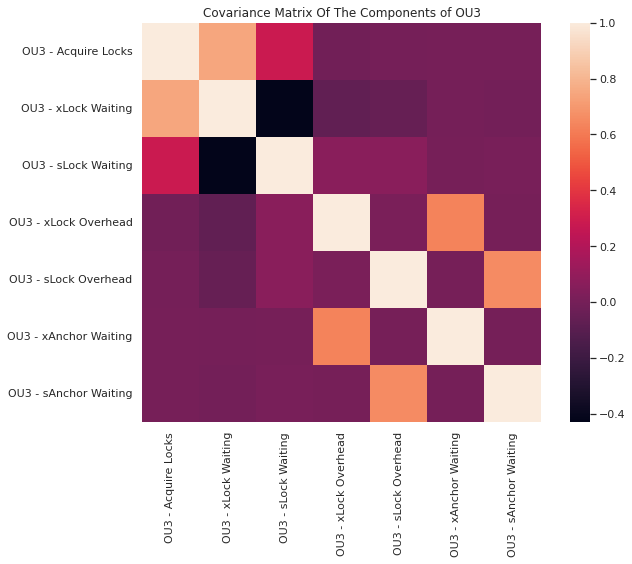

x_series: (7,) | features: (7,)


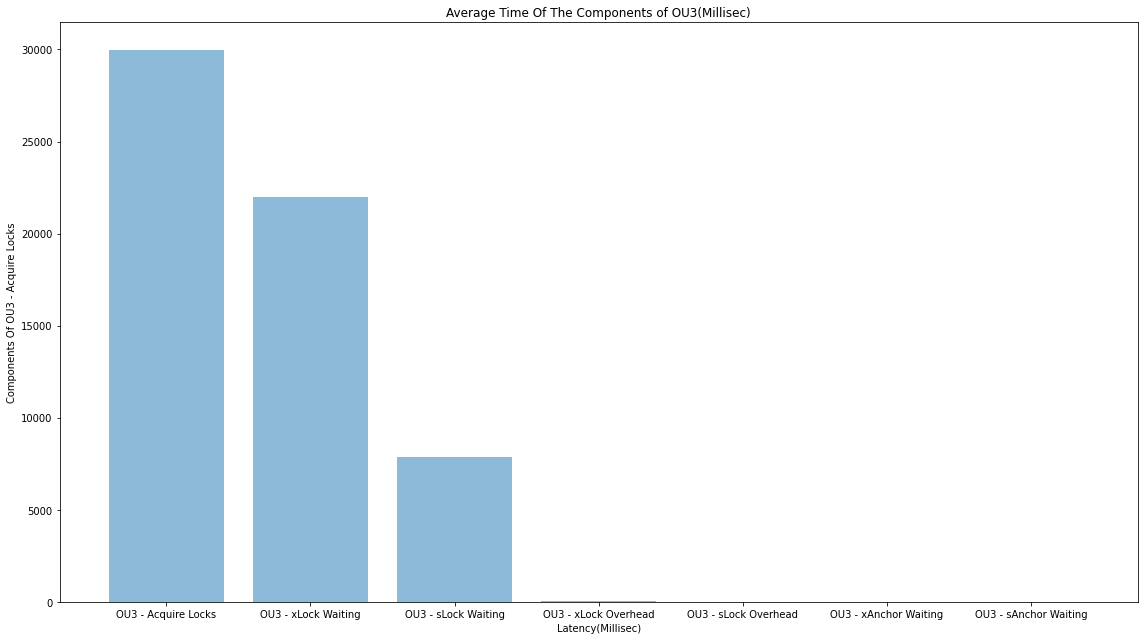

In [31]:
import matplotlib.pyplot as plt # matplotlib 3.1.1
import seaborn as sns # seaborn 0.9.0
from sklearn.preprocessing import StandardScaler # scikit-learn 0.21.3

print(f"OUs features")
# display(df_train_X.iloc[:, [1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]])
display(df_train_X.iloc[:, [1, 8, 9, 10, 11, 12, 13, 14, 15]])

features = df_train_X.iloc[:, [8, 9, 10, 11, 12, 13, 14]]

draw_cov_mat(features=features, 
             title="Covariance Matrix Of The Components of OU3", 
             path="./figure/ou3_comps_cov.png")

draw_bar_chart(features=features, 
               title='Average Time Of The Components of OU3(Millisec)', 
               xlabel='Components Of OU3 - Acquire Locks', 
               ylabel='Latency(Millisec)', 
               path='./figure/ou3_comps_avg_lat.png')

# Data Preparation and fitting

In [26]:
def reshape_dataset(seq_len: int, dataset: pd.DataFrame, seq_num: int=None):
    # Set the Length of Sequence
    seq_len = 200

    # Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
    values = dataset.values
    n = values.shape[0]
    if seq_num is None:
        seq_num = n // seq_len
    series_n = seq_num * seq_len
    print(f"Dataset shape: {values.shape}, Length of Sequence: {seq_len}, Number of Sequence: {seq_num}, Number of Series: {series_n}")
    values_truncated = values[:series_n]

    # n_train_time = 4000
    # train = values_truncated[:n_train_time, :]
    # test = values_truncated[n_train_time:, :]
    # train_x, train_y = train[:, :-1], train[:, -1]
    # test_x, test_y = test[:, :-1], test[:, -1]

    # Shape: [number of sequences, sequence lengh, feature size]
    # train_x = train_x.reshape((train_x.shape[0] // seq_len, seq_len, train_x.shape[1]))
    # test_x = test_x.reshape((test_x.shape[0] // seq_len, seq_len, test_x.shape[1]))
    # train_y = train_y.reshape((train_y.shape[0] // seq_len, seq_len))
    # test_y = test_y.reshape((test_y.shape[0] // seq_len, seq_len))
    
    df_dataset = values_truncated.reshape((values_truncated.shape[0] // seq_len, seq_len, values_truncated.shape[1]))
    return df_dataset

In [27]:
seq_len = 200

train_x, train_y = reshape_dataset(seq_len=seq_len, dataset=df_train_X), reshape_dataset(seq_len=seq_len, dataset=df_train_Y)
test_x, test_y = reshape_dataset(seq_len=seq_len, dataset=df_train_X), reshape_dataset(seq_len=seq_len, dataset=df_train_Y)

Dataset shape: (299248, 59), Length of Sequence: 200, Number of Sequence: 1496, Number of Series: 299200
Dataset shape: (299248, 1), Length of Sequence: 200, Number of Sequence: 1496, Number of Series: 299200
Dataset shape: (299248, 59), Length of Sequence: 200, Number of Sequence: 1496, Number of Series: 299200
Dataset shape: (299248, 1), Length of Sequence: 200, Number of Sequence: 1496, Number of Series: 299200


In [28]:
print(f'train_x shape: {train_x.shape}')
print(f'train_y shape: {train_y.shape}')
print(f'test_x shape: {test_x.shape}')
print(f'test_y shape: {test_y.shape}')

train_x shape: (1496, 200, 59)
train_y shape: (1496, 200, 1)
test_x shape: (1496, 200, 59)
test_y shape: (1496, 200, 1)


<h3> LSTM model setting <h3>

(1) 100 neurons in the first visible layer

(2) dropout 10%

(3) 1 neuron in the output layer for predicting Global_active_power

(4) The input shape will be 1 time step with 7 features

(5) The mean_squared_error loss function and the efficient adam version of stochastic gradient descent

(6) The model will be fit for 50 training epochs with a batch size of 70.

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, RNN, Input
from tensorflow.nn import relu

import tensorflow.keras as keras

from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

In [11]:
%load_ext tensorboard

# Dynamic LSTM

function:
math::
$$
\begin{array}{ll}
i_t = \sigma(W_{xi} x_t + W_{hi} h_{(t-1)} + b_{i}) \\
f_t = \sigma(W_{xf} x_t + W_{hf} h_{(t-1)} + b_{f}) \\
c_t = f_t \odot c_{t-1} + i_t \odot \tanh(W_{xc} x_t + W_{hc} h_{(t-1)} + b_{c}) \\
o_t = \sigma(W_{xo} x_t + W_{ho} h_{(t-1)} + b_{o}) \\
h_t = o_t \odot \tanh(c_t)
\end{array}
$$

where $h_t$ is the hidden state at time $t$, $x_t$ is the input at time $t$, $h_{(t-1)}$ is the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$, and $i_t$,
$f_t$, $o_t$ are the input, forget, and output gates, respectively.
$\sigma$ is the sigmoid function, and $\odot$ is the Hadamard product(element-wise product).

In [12]:
from tensorflow.math import multiply
from tensorflow.keras.activations import sigmoid, tanh

class DynamicLSTM(keras.layers.Layer):
    def __init__(self, units, memory_size=3, **kwargs):
        super(DynamicLSTM, self).__init__(**kwargs)
        # Must have variables
        self.units = units
        # self.state_size = [tf.TensorShape([memory_size, units])]
        self.state_size = [tf.TensorShape([units]), tf.TensorShape([memory_size])]

        # Custom variables
        self.memory_size = memory_size

    def build(self, input_shape):
        # print(f"input_shape: {input_shape}")
        self.input_gate_h_kernel = self.add_weight(shape=(self.units, self.memory_size),
                                                   initializer='uniform',
                                                   name='input_gate_h_kernel')
        self.input_gate_x_kernel = self.add_weight(shape=(input_shape[-1], self.memory_size),
                                                   initializer='uniform',
                                                   name='input_gate_x_kernel')
        
        self.forget_gate_h_kernel = self.add_weight(shape=(self.units, self.memory_size),
                                                   initializer='uniform',
                                                   name='forget_gate_h_kernel')
        self.forget_gate_x_kernel = self.add_weight(shape=(input_shape[-1], self.memory_size),
                                                   initializer='uniform',
                                                   name='forget_gate_x_kernel')
        
        self.output_gate_h_kernel = self.add_weight(shape=(self.units, self.units),
                                                   initializer='uniform',
                                                   name='output_gate_h_kernel')
        self.output_gate_x_kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                                   initializer='uniform',
                                                   name='output_gate_x_kernel')
        
        self.cell_h_kernel = self.add_weight(shape=(self.units, self.memory_size),
                                             initializer='uniform',
                                             name='cell_h_kernel')
        self.cell_x_kernel = self.add_weight(shape=(input_shape[-1], self.memory_size),
                                             initializer='uniform',
                                             name='cell_x_kernel')
        
        self.reshape_cell_kernel = self.add_weight(shape=(self.memory_size, self.units), 
                                                   initializer='uniform', 
                                                   name='cell_x_kernel')
        
        self.built = True
    
    def input_gate(self, x, h):
        # Equation 1. input gate
        h_out = tf.tensordot(h, self.input_gate_h_kernel, axes=1)
        x_out = tf.tensordot(x, self.input_gate_x_kernel, axes=1)
        return sigmoid(h_out + x_out)
    
    def forget_gate(self, x, h):
        # Equation 2. forget gate
        h_out = tf.tensordot(h, self.forget_gate_h_kernel, axes=1)
        x_out = tf.tensordot(x, self.forget_gate_x_kernel, axes=1)
        return sigmoid(h_out + x_out)
    
    def output_gate(self, x, h):
        # Equation 3. output gate
        h_out = tf.tensordot(h, self.output_gate_h_kernel, axes=1)
        x_out = tf.tensordot(x, self.output_gate_x_kernel, axes=1)
        return sigmoid(h_out + x_out)
    
    def cell(self, i, f, x, h, c_prev):
        h_out = tf.tensordot(h, self.cell_h_kernel, axes=1)
        x_out = tf.tensordot(x, self.cell_x_kernel, axes=1)
        k = relu(h_out + x_out)

        # new information part that will be injected in the new context
        return multiply(f, c_prev) + multiply(i, k)
    
    def generate_indice(self, states):
        batch_size = states.shape[0]
        # Random select
        return tf.random.uniform((batch_size, 1), minval=0, maxval=self.memory_size, dtype=tf.dtypes.int32)

    def select_memory(self, states):
        batch_size = states.shape[0]
        indice = self.generate_indice(states)

        # The sequence number for Indices
        sequence = tf.range(start=0, limit=batch_size)
        sequence = tf.reshape(sequence, (sequence.shape[0], 1))

        # Indices for gather_nd
        gather_indice = tf.concat([sequence, indice], axis=1)

        # Grab the selected datas according to the indice
        selected_state = tf.gather_nd(states, gather_indice)
        return selected_state
    
    def regular_lstm(self, x, states):
        prev_hidden = states[0]
        prev_cell = states[1]
        
        i = self.input_gate(x, prev_hidden)
        f = self.forget_gate(x, prev_hidden)
        o = self.output_gate(x, prev_hidden)
        
        next_cell = self.cell(i, f, x, prev_hidden, prev_cell)
        next_hidden = multiply(o, relu(tf.tensordot(next_cell, self.reshape_cell_kernel, axes=1)))

        return next_hidden, [next_hidden, next_cell]

    def call(self, x, states):
        # print(f"{states.shape}")
        prev_hidden = states[0]
        prev_cell = states[1]
        
        i = self.input_gate(x, prev_hidden)
        f = self.forget_gate(x, prev_hidden)
        o = self.output_gate(x, prev_hidden)
        
        next_cell = self.cell(i, f, x, prev_hidden, prev_cell)
        next_hidden = multiply(o, relu(tf.tensordot(next_cell, self.reshape_cell_kernel, axes=1)))

        return next_hidden, [next_hidden, next_cell]
    
    # def get_config(self):
    #     return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}

def getLSTM(inputShape, memory_size):
    rnnLayer = RNN(DynamicLSTM(100, memory_size=memory_size), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    x = rnnLayer(inputs)
    x = relu(x)
    x = Dense(100)(x)
    x = relu(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    # opt = tf.keras.optimizers.Adam()
    model.compile(loss='mean_squared_error', optimizer='adam')
    # model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()

    return model

# Real Data Dynamic RNN

In [13]:
from tqdm.keras import TqdmCallback

class RealDataDynamicRNN(keras.layers.Layer):
    def __init__(self, units, memory_size=200, **kwargs):
        super(RealDataDynamicRNN, self).__init__(**kwargs)
        # Must have variables
        self.units = units
        self.memory_width = units
        self.state_size = tf.TensorShape([memory_size, self.memory_width])

        # Custom variables
        self.memory_size = memory_size
        
        # OUs
        self.front_ous_indices = [1, 4, 5, 6, 7]
        self.front_ous_len = len(self.front_ous_indices)
        self.back_ous_indices = [9, 10, 11, 12, 14]
        self.back_ous_len = len(self.back_ous_indices)
        self.lock_index = [8]
        
        # Dependent OUs
        self.last_ou_idx = self.back_ous_indices[-1] + 1

    def build(self, input_shape):
        # self.kernel = self.add_weight(
        #     shape=(input_shape[-1], self.units),
        #     initializer='uniform',
        #     name='kernel')
        # self.recurrent_kernel = self.add_weight(
        #     shape=(self.units, self.units),
        #     initializer='uniform',
        #     name='recurrent_kernel')
        
        self.front_ou_kernel = self.add_weight(
            shape=(self.front_ous_len, 1),
            initializer='uniform',
            name='front_ou_kernel')
        self.back_ou_kernel = self.add_weight(
            shape=(self.back_ous_len, 1),
            initializer='uniform',
            name='back_ou_kernel')
        self.lock_kernel = self.add_weight(
            shape=(1, 1),
            initializer='uniform',
            name='lock_kernel')
        
        self.built = True
    
    def generate_indice(self, states):
        batch_size = states.shape[0]
        # Random select
        return tf.random.uniform((batch_size, 1), minval=0, maxval=self.memory_size, dtype=tf.dtypes.int32)
    
    def get_max_depend_txn_end_time(self, inputs, states):
        # Dependent Txns Indices
        # Shape: [batch_size, max_depend_txn_num]
        depends_idx = inputs[:, self.last_ou_idx:]
        depends_idx = tf.cast(depends_idx, tf.int32)
        # print(f"depends_idx shape: {depends_idx.shape}")
        max_depend_txn_num = depends_idx.shape[-1]
        
        # Lock time in memory
        batch_size = states.shape[0]
        # print(f"max_depend_txn_num: {max_depend_txn_num} | batch_size: {batch_size}")
        # Shape: [batch_size, 1, self.memory_width]
        dummy_lock_times = tf.zeros([batch_size, 1, self.memory_width])
        # print(f"dummy_lock_times shape: {dummy_lock_times.shape}")
        # Concatenate a dummy lock time for easier indexing
        # Shape: [batch_size, self.memory_size + 1, self.memory_width]
        depend_lock_times_pad = tf.concat([dummy_lock_times, states], axis=1)
        # print(f"depend_lock_times_pad shape: {depend_lock_times_pad.shape}")
        
        # Indice of selecting dependent txns
        # Shape: [batch_size, max_depend_txn_num, 1]
        depends_idx_exp = tf.expand_dims(depends_idx, -1)
        # print(f"depends_idx_exp shape: {depends_idx_exp.shape}")
        
        # Indice for each batch
        # Shape: [batch_size]
        sequence = tf.range(start=0, limit=batch_size)
        # print(f"range sequence shape: {sequence.shape}")
        # Shape: [batch_size, 1, 1]
        sequence = tf.reshape(sequence, (sequence.shape[0], 1, 1))
        # print(f"reshape sequence shape: {sequence.shape}")
        # Shape: [batch_size, max_depend_txn_num, 1]
        sequence = tf.tile(sequence, (1, depends_idx.shape[1], 1))
        # print(f"tile sequence shape: {sequence.shape}")
        # Form a complete indice
        # Shape: [batch_size, max_depend_txn_num, 2]
        depend_lock_indice = tf.concat([sequence, depends_idx_exp], axis=2)
        # print(f"depend_lock_indice shape: {depend_lock_indice.shape}")
        
        # Select dependenet lock times
        # Shape: [batch_size, max_depend_txn_num, 1]
        depend_lock_times = tf.gather_nd(depend_lock_times_pad, depend_lock_indice)
        # print(f"depend_lock_times shape: {depend_lock_times.shape}")
        # Choose maximum lock time
        # Shape: [batch_size, 1, 1]
        max_lock_end_times = tf.math.reduce_max(depend_lock_times, axis=1)
        # print(f"max_lock_end_times shape: {max_lock_end_times.shape}")
        
        return max_lock_end_times

    def select_memory(self, states):
        batch_size = states.shape[0]
        indice = self.generate_indice(states)

        # The sequence number for Indices
        sequence = tf.range(start=0, limit=batch_size)
        sequence = tf.reshape(sequence, (sequence.shape[0], 1))

        # Indices for gather_nd
        gather_indice = tf.concat([sequence, indice], axis=1)

        # Grab the selected datas according to the indice
        selected_state = tf.gather_nd(states, gather_indice)
        return selected_state
    
    def calibrate_front_ou(self, ous):
        x = tf.tensordot(ous, self.front_ou_kernel, axes=1)
        # x = relu(x)
        return x
    
    def est_front_ou_end_time(self, inputs):
        ous = tf.gather(inputs, self.front_ous_indices, axis=1)
        # est_end_time = tf.tensordot(ous, self.front_ou_kernel, axes=1)
        est_end_time = self.calibrate_front_ou(ous)
        # print(f"Front - inputs: {inputs.shape} | ous: {ous.shape} | est_end_time: {est_end_time.shape}")
        return est_end_time
    
    def calibrate_back_ou(self, ous):
        x = tf.tensordot(ous, self.back_ou_kernel, axes=1)
        # x = relu(x)
        return x
    
    def est_back_ou_end_time(self, inputs):
        ous = tf.gather(inputs, self.back_ous_indices, axis=1)
        # est_end_time = tf.tensordot(ous, self.back_ou_kernel, axes=1)
        est_end_time = self.calibrate_back_ou(ous)
        # print(f"Back - inputs: {inputs.shape} | ous: {ous.shape} | est_end_time: {est_end_time.shape}")
        return est_end_time
    
    def calibrate_lock(self, lock):
        x = tf.tensordot(lock, self.lock_kernel, axes=1)
        # x = relu(x)
        return x
    
    def est_lock_end_time(self, inputs, states):
        est_front = self.est_front_ou_end_time(inputs)
        lock_wait_end_time = self.get_max_depend_txn_end_time(inputs, states)
        # lock_waiting_time = tf.math.reduce_max(selected_state, axis=1, keepdims=True)
        
        est_times_comp = tf.concat([est_front, lock_wait_end_time], axis=1)
        est_times = tf.math.reduce_max(est_times_comp, axis=1, keepdims=True)
        # print(f"Lock - lock_waiting_time: {lock_waiting_time.shape} | selected_state: {selected_state.shape} | lock_waiting_time: {lock_waiting_time.shape} | est_times_comp: {est_times_comp.shape} | est_times: {est_times.shape}")
        return self.calibrate_lock(est_times)
    
    def feat_lock_end_time(self, inputs, states):
        est_front = self.est_front_ou_end_time(inputs)
        est_lock = tf.gather(inputs, self.lock_index, axis=1)
        est_end_time = self.calibrate_lock(est_lock)
        return est_front + est_end_time
    
    def est_txn_end_time(self, inputs, states):
        est_lock = self.est_lock_end_time(inputs, states)
        # est_lock = self.feat_lock_end_time(inputs, states)
        est_back = self.est_back_ou_end_time(inputs)
        est_txn_time = est_lock + est_back
        
        # print(f"est_lock: {est_lock.shape} | est_back: {est_back.shape} | est_txn_time: {est_txn_time.shape}")
        return est_txn_time
        
    def call(self, inputs, states):
        memory = states[0]
        # print(f"inputs: {inputs.shape} | memory: {memory.shape}")

        # Recurrent NN
        # h = tf.tensordot(inputs, self.kernel, axes=1)
        # selected_state = self.select_memory(states[0])
        # output = h + tf.tensordot(selected_state, self.recurrent_kernel, axes=1)
        
        output = self.est_txn_end_time(inputs, memory)

        # Concat new state
        new_state = tf.reshape(output, (output.shape[0], 1, output.shape[1]))
        output_states = tf.concat([new_state, memory], axis=1)
        output_states = output_states[:, 0:self.memory_size, :]

        return output, [output_states]

def getRDRNNModel(inputShape, memory_size, lr):
    rnnLayer = RNN(RealDataDynamicRNN(1, memory_size=memory_size), dynamic=True, return_sequences=True, return_state=False)

    inputs = Input(shape=inputShape)
    x = rnnLayer(inputs)
    # x = relu(x)
    # x = Dense(100)(x)
    # x = relu(x)
    x = Dropout(0.1)(x)
    outputs = Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    # model.compile(loss='mean_squared_error', optimizer='adam')
    model.compile(loss='mean_squared_error', optimizer=opt)
    model.summary()

    return model

In [14]:
import datetime
import os

def name_fn(batch_size, memory_size, epochs, lr):
    return f"bs-{batch_size}_ms-{memory_size}_ep-{epochs}_lr-{lr}"
    
def makepaths(p):
    if p is None:
        return 
    if not os.path.isdir(p):
        os.makedirs(p)
    else:
        dir_name = os.path.dirname(p)
        if not os.path.isdir(dir_name):
            os.makedirs(dir_name)
    
def train(batch_size, memory_size, epochs, lr, train_x, test_x, is_show=False, fig_path=None):
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
      # Restrict TensorFlow to only use the first GPU
      try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
      except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
    # batch_size = 70
    # memory_size = 200
    # epochs = 20

    print(f"train_x: {train_x.shape} | train_y: {train_y.shape}")
    print(f"test_x: {test_x.shape} | test_y: {test_y.shape}")
    # model = getVanillaRNN((train_x.shape[1], train_x.shape[2]))
    # model = getModel((train_x.shape[1], train_x.shape[2]), memory_size=memory_size)
    model = getRDRNNModel((train_x.shape[1], train_x.shape[2]), memory_size=memory_size, lr=lr)
    # model = getSingleUnitRNN((train_x.shape[1], train_x.shape[2]), memory_size=memory_size)
    # model = getLSTM((train_x.shape[1], train_x.shape[2]), memory_size=memory_size)

    # Network fitting
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(train_x, train_y, batch_size=batch_size,
                        epochs=epochs, workers=8, use_multiprocessing=True,
                        validation_data=(test_x, test_y), verbose=0, 
                        callbacks=[tensorboard_callback, TqdmCallback(verbose=1)])

    # Loss history plot
    plt.figure(figsize=(16,9)) 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss | batch: {batch_size} | memory: {memory_size} | ep: {epochs} | lr: {lr}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    if fig_path is not None:
        makepaths(os.path.dirname(fig_path))
        plt.savefig(fig_path)
    if is_show:
        plt.show()
        
    return model
    
def evaluate(model, test_x, test_y, test_samples=500, is_show=False, fig_path=None):
    # Prediction test
    pred_y = model.predict(test_x)
    pred_y = pred_y.reshape((-1, 1))
    real_y = test_y.reshape((-1, 1))
    total_samples = real_y.shape[0]

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(pred_y, real_y))
    print('Test RMSE: %.3f' % rmse)
    
    if test_samples < 0:
        test_samples = total_samples

    aa = [x for x in range(test_samples)]
    plt.figure(figsize=(25,10)) 
    plt.plot(aa, real_y[:test_samples], marker='.', label="actual")
    plt.plot(aa, pred_y[:test_samples], 'r', label="prediction")
    plt.ylabel(df_train_Y.columns[0], size=15)
    plt.xlabel(f'First {test_samples} Txns', size=15)
    plt.legend(fontsize=15)
    if fig_path is not None:
        makepaths(os.path.dirname(fig_path))
        plt.savefig(fig_path)
    if is_show:
        plt.show()
    
def train_eval(batch_size, memory_size, epochs, lr, test_samples=1000, base_dir=None, is_show=False, is_save=False):
    is_show = False
    if base_dir is None:
        base_dir = '/home/ccchen/sychou/dynamic_RNN/output'
    fig_path = os.path.join(base_dir, name_fn(batch_size=batch_size, memory_size=memory_size, epochs=epochs, lr=lr))
    train_fig = os.path.join(f"{fig_path}", "train.png")
    eval_fig = os.path.join(f"{fig_path}", "eval.png")
    makepaths(fig_path)
    
    model = train(batch_size=batch_size, memory_size=memory_size, epochs=epochs, lr=lr, train_x=train_x, test_x=test_x, 
                  is_show=is_show, fig_path=train_fig)
    evaluate(model=model, test_x=test_x, test_y=test_y, test_samples=test_samples, is_show=is_show, fig_path=eval_fig)

2021-12-20 00:05:05.505030: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-20 00:05:06.080585: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9661 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5


4 Physical GPUs, 1 Logical GPU
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 56)]         0         
_________________________________________________________________
rnn (RNN)                    (None, 200, 200, 1)       0 (unused)
_________________________________________________________________
dropout (Dropout)            (None, 200, 200, 1)       0         
_________________________________________________________________
dense (Dense)                (None, 200, 200, 1)       2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2021-12-20 00:05:06.544412: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Test RMSE: 105035378.206


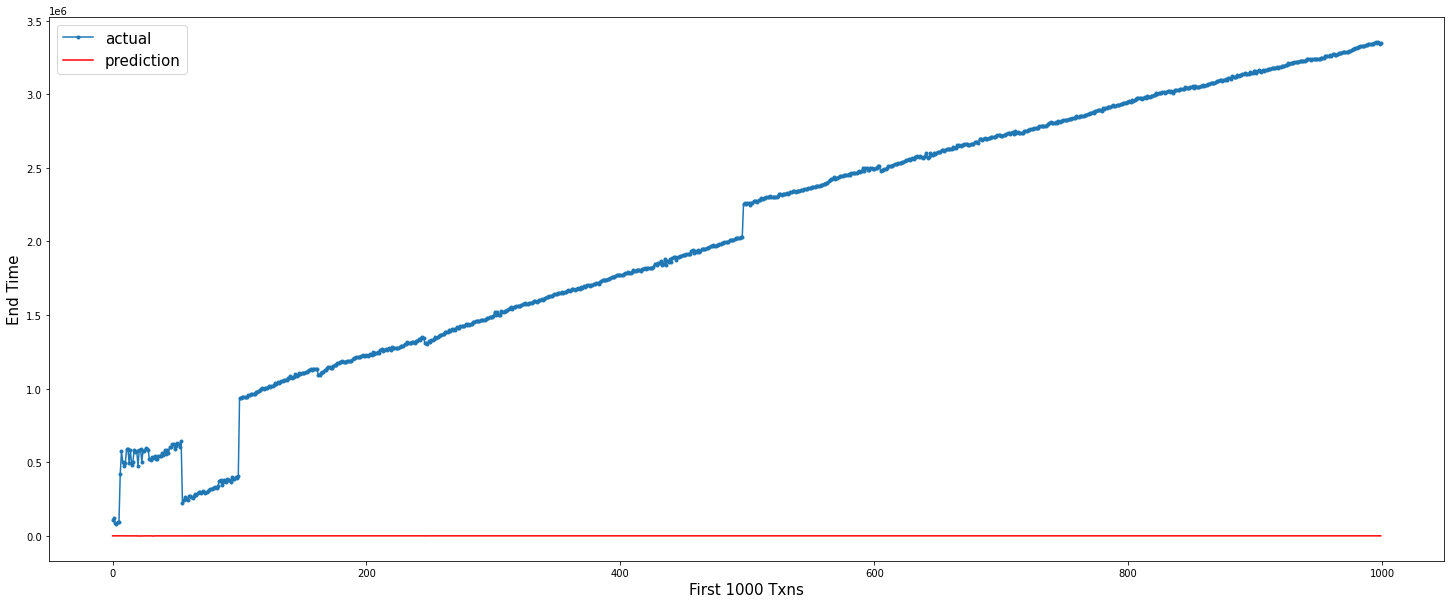

In [15]:
memory_size = 200
lr = 0.1

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
model = getRDRNNModel((train_x.shape[1], train_x.shape[2]), memory_size=memory_size, lr=lr)
evaluate(model, test_x, test_y, test_samples=1000, is_show=True, fig_path='/home/ccchen/sychou/dynamic_RNN/temp')

In [16]:
from scalablerunner.taskrunner import TaskRunner

base_dir = '/home/ccchen/sychou/dynamic_RNN/output'
is_save = True
# train_eval(batch_size=70, memory_size=200, epochs=2, lr=0.1, train_x=train_x, test_x=test_x, test_y=test_y, base_dir=base_dir, is_save=is_save)
       
# if __name__ == '__main__':
# config = {
#     'Section: Tuning Dynamic RNN': { # Each section would be executed sequentially.
#         'GTX 2080': { # The groups under the same section would be executed concurrently
#             'Call': train_eval, # Call can be either a function call or a command in string
#             'Param': { # The TaskRunner would list all kinds of combination of the parameters and execute them once
#                 'batch_size': [32, 64, 128, 256],
#                 'memory_size': [200],
#                 'epochs': [40, 80],
#                 'lr': [0.001, 0.01, 0.05, 0.1, 0.5, 1],
#                 # 'train_x': [train_x],
#                 # 'test_x': [test_x],
#                 # 'test_y': [test_y],
#                 'base_dir': [base_dir],
#                 'is_save': [is_save],
#             },
#             # 'Async': { # The task under the same group would be schedule to the resources by TaskRunner during runtime.
#             #     'gpu': [0, 2, 3]
#             # }
#         },  
#     },
#     # 'Another Section': {
#     #     'A dummy group': {
#     #         'Call': 'ls',
#     #         'Param': {
#     #             '': ['-a']
#     #         }
#     #     }
#     # }
# }

# tr = TaskRunner(config=config)
# tr.run()

# Reference

Tensorflow 2.0 APIs
- [tf.range](https://www.tensorflow.org/api_docs/python/tf/range)
- [tf.gather_nd](https://www.tensorflow.org/api_docs/python/tf/gather_nd)
- [tf.keras.layers.RNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN)
- [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
  - Also contain the example code of `return_sequences` and `return_state`
- [tf.tensordot](https://www.tensorflow.org/api_docs/python/tf/tensordot)
- [Introduction to tensor slicing](https://www.tensorflow.org/guide/tensor_slicing)